# **Task-1: Video Processing with OpenCV**

In [ ]:
import cv2
import numpy as np
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import pytesseract
from google.colab.patches import cv2_imshow
import ipywidgets as widgets
from IPython.display import display as ipy_display
import time

# # Install required packages
# !pip install opencv-python-headless pytesseract
# !sudo apt install tesseract-ocr
# !pip install pillow

# Create a more reliable camera capture function
def get_webcam_image():
    # JavaScript code to capture image from webcam
    js = Javascript('''
    async function capture() {
        const div = document.createElement('div');
        const video = document.createElement('video');
        video.style.display = 'block';

        // Create capture button
        const captureBtn = document.createElement('button');
        captureBtn.textContent = 'Capture';
        captureBtn.style.position = 'absolute';
        captureBtn.style.bottom = '20px';
        captureBtn.style.left = '50%';
        captureBtn.style.transform = 'translateX(-50%)';
        captureBtn.style.padding = '10px 20px';
        captureBtn.style.backgroundColor = '#4285F4';
        captureBtn.style.color = 'white';
        captureBtn.style.border = 'none';
        captureBtn.style.borderRadius = '5px';

        // Add elements to div
        div.appendChild(video);
        div.appendChild(captureBtn);
        document.body.appendChild(div);

        // Request camera access
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        // Resize output to fit video
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for capture button click
        await new Promise((resolve) => {
            captureBtn.onclick = resolve;
        });

        // Capture image
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        const dataUrl = canvas.toDataURL('image/jpeg');

        // Clean up
        stream.getVideoTracks()[0].stop();
        div.remove();

        return dataUrl;
    }
    ''')

    # Display JavaScript and capture image
    display(js)
    data_url = eval_js('capture()')
    binary = b64decode(data_url.split(',')[1])

    # Convert to numpy array
    jpg = np.frombuffer(binary, dtype=np.uint8)
    img = cv2.imdecode(jpg, cv2.IMREAD_COLOR)

    return img

def video_capture_task():
    """Grayscale video capture task"""
    print("Click 'Capture' button to take photos")
    print("The stop button will appear after first capture")

    # Create stop button
    stop_button = widgets.Button(description="Stop", button_style='danger')

    def on_stop_clicked(b):
        stop_button.disabled = True

    stop_button.on_click(on_stop_clicked)

    while not stop_button.disabled:
        try:
            # Capture image
            img = get_webcam_image()

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Display results
            clear_output(wait=True)
            print("Original Image:")
            cv2_imshow(img)
            print("\nGrayscale Image:")
            cv2_imshow(gray)

            # Show stop button after first capture
            ipy_display(stop_button)

        except Exception as e:
            print(f"Error: {str(e)}")
            break

    print("Task completed")

def motion_detection_task():
    """Motion detection task"""
    print("First capture will be background image (no motion)")
    print("Subsequent captures will detect motion")

    # Capture background
    background = get_webcam_image()
    background_gray = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    background_gray = cv2.GaussianBlur(background_gray, (21, 21), 0)

    # Create stop button
    stop_button = widgets.Button(description="Stop", button_style='danger')

    def on_stop_clicked(b):
        stop_button.disabled = True

    stop_button.on_click(on_stop_clicked)

    while not stop_button.disabled:
        try:
            # Capture current frame
            frame = get_webcam_image()
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (21, 21), 0)

            # Compute difference
            diff = cv2.absdiff(background_gray, gray)
            _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
            thresh = cv2.dilate(thresh, None, iterations=2)

            # Find contours
            contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Draw rectangles
            for contour in contours:
                if cv2.contourArea(contour) > 500:
                    (x, y, w, h) = cv2.boundingRect(contour)
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Display results
            clear_output(wait=True)
            print("Motion Detection:")
            cv2_imshow(frame)
            print("\nThreshold:")
            cv2_imshow(thresh)

            # Show stop button
            ipy_display(stop_button)

        except Exception as e:
            print(f"Error: {str(e)}")
            break

    print("Task completed")

def ocr_task():
    """OCR task"""
    print("Capture an image containing text")

    # Create stop button
    stop_button = widgets.Button(description="Stop", button_style='danger')

    def on_stop_clicked(b):
        stop_button.disabled = True

    stop_button.on_click(on_stop_clicked)

    while not stop_button.disabled:
        try:
            # Capture image
            img = get_webcam_image()

            # Preprocess for OCR
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.medianBlur(gray, 3)
            _, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Perform OCR
            text = pytesseract.image_to_string(gray)

            # Display results
            clear_output(wait=True)
            print("Original Image:")
            cv2_imshow(img)
            print("\nProcessed for OCR:")
            cv2_imshow(gray)
            print("\nDetected Text:")
            print("="*40)
            print(text.strip())
            print("="*40)

            # Show stop button
            ipy_display(stop_button)

        except Exception as e:
            print(f"Error: {str(e)}")
            break

    print("Task completed")

def main():
    print("OpenCV Tasks in Colab")
    print("1. Grayscale Video Capture")
    print("2. Motion Detection")
    print("3. OCR")
    print("4. Exit")

    while True:
        choice = input("\nEnter choice (1-4): ").strip()

        if choice == '1':
            video_capture_task()
        elif choice == '2':
            motion_detection_task()
        elif choice == '3':
            ocr_task()
        elif choice == '4':
            print("Exiting...")
            break
        else:
            print("Invalid choice")

if __name__ == "__main__":
    main()

OpenCV Tasks in Colab
1. Grayscale Video Capture
2. Motion Detection
3. OCR
4. Exit

Enter choice (1-4): 4
Exiting...


In [ ]:
# Install required packages for Colab
!pip install opencv-python pytesseract
!sudo apt install tesseract-ocr
!pip install pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


#**Task 2: Face Emotion Recognition System**

Loading images...


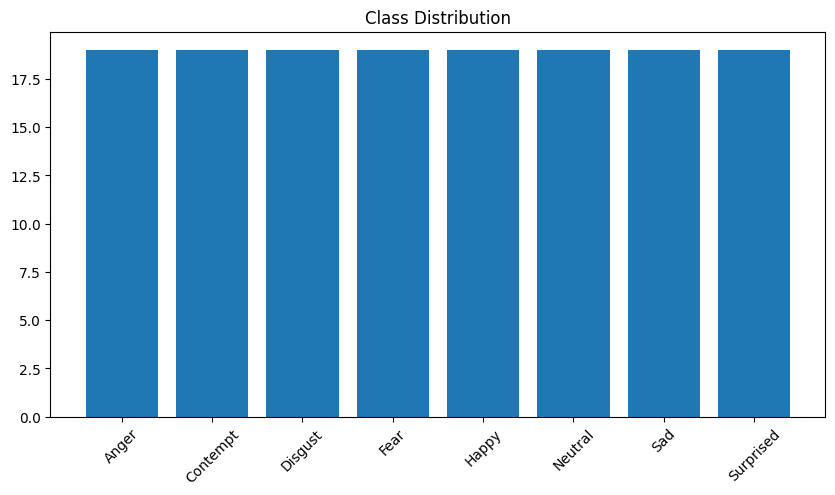

Splitting data...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,784,488 (10.62 MB)

 Trainable params: 2,782,056 (10.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

Training model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/3 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.1039 - loss: 22.3075  
Epoch 1: val_accuracy improved from -inf to 0.06452, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.1025 - loss: 22.3053 - val_accuracy: 0.0645 - val_loss: 18.2007 - learning_rate: 1.0000e-04
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0625 - loss: 23.5698
Epoch 2: val_accuracy improved from 0.06452 to 0.09677, saving model to best_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.0625 - loss: 23.5698 - val_accuracy: 0.0968 - val_loss: 18.1952 - learning_rate: 1.0000e-04
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2188 - loss: 24.4093
Epoch 3: val_accuracy did not improve from 0.09677
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1875 - loss: 23.6215 - val_accuracy: 0.0968 - val_loss: 18.1904 - learning_rate: 1.0000e-04
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1250 - loss: 24.1712
Epoch 4: val_accuracy did not improve from 0.09677
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1250 - loss: 24.1712 - val_accuracy: 0.0968 - val_loss: 18.1889 - learning_rate: 1.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1458 - loss: 22.5383
Epoch 5: val_accuracy improved from 0.09677 to 0.16129, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.1406 - loss: 22.6340 - val_accuracy: 0.1613 - val_loss: 18.1843 - le

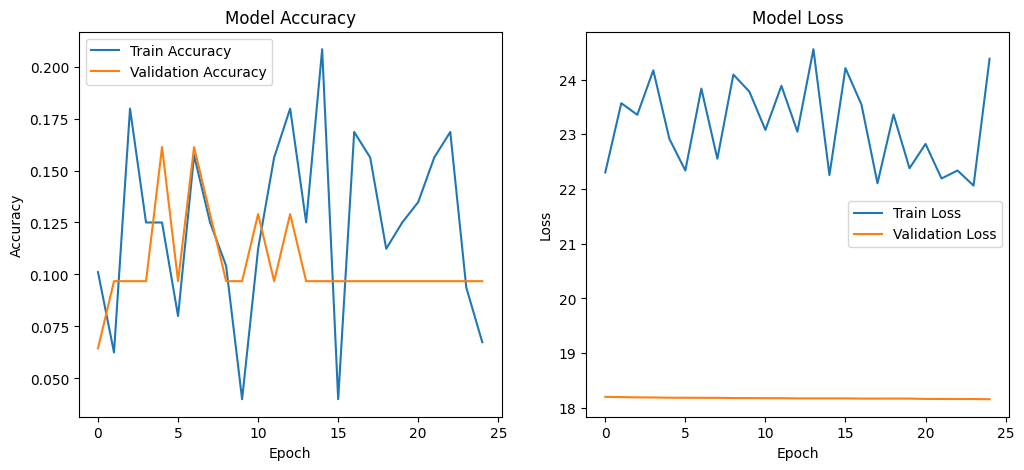

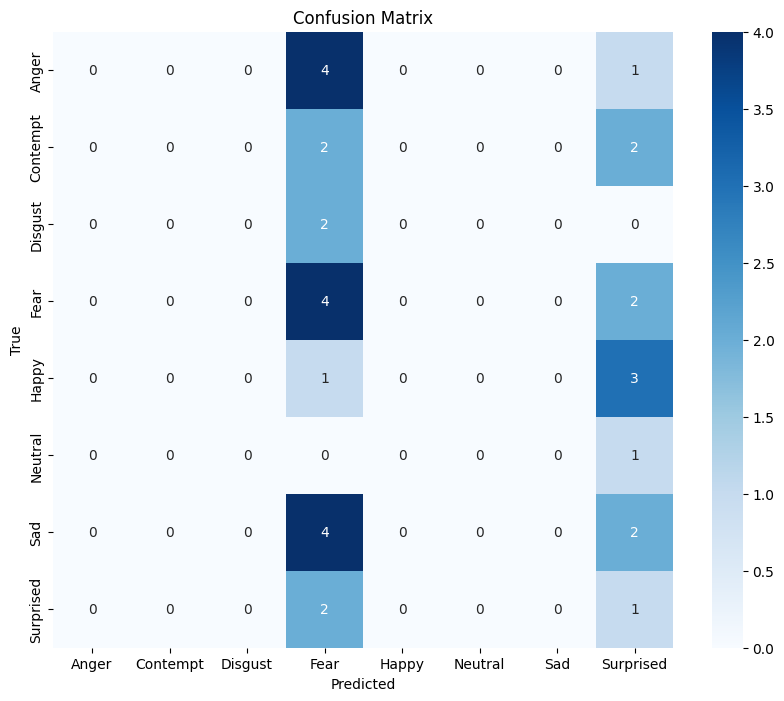

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# Constants
IMG_SIZE = (48, 48)
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SHAPE = (*IMG_SIZE, 1)  # Grayscale images

# Emotion labels
EMOTIONS = {
    0: 'Anger',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happy',
    5: 'Neutral',
    6: 'Sad',
    7: 'Surprised'
}
NUM_CLASSES = len(EMOTIONS)

# Load metadata
emotions_path = '/content/drive/MyDrive/archive/emotions.csv'
df = pd.read_csv(emotions_path)

# Enhanced image loading with validation
def load_images(base_path='/content/drive/MyDrive/archive/images'):
    images = []
    labels = []
    set_ids = []

    for set_id in df['set_id']:
        set_path = os.path.join(base_path, str(set_id))
        if os.path.exists(set_path):
            for emotion_idx, emotion in EMOTIONS.items():
                img_path = os.path.join(set_path, f"{emotion}.jpg")
                if os.path.exists(img_path):
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is None:
                            continue

                        img = cv2.resize(img, IMG_SIZE)
                        img = img.astype('float32') / 255.0

                        images.append(img)
                        labels.append(emotion_idx)
                        set_ids.append(set_id)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")

    if len(images) == 0:
        raise ValueError("No images loaded. Check paths and directory structure.")

    return np.array(images), np.array(labels), np.array(set_ids)

# Load dataset
print("Loading images...")
X, y, set_ids = load_images()

# Visualize class distribution
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10,5))
plt.bar([EMOTIONS[u] for u in unique], counts)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Reshape for CNN
X = X.reshape(-1, *INPUT_SHAPE)
y = to_categorical(y, num_classes=NUM_CLASSES)

# Split data with stratification
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=set_ids, random_state=42
)

# Calculate class weights with more aggressive balancing
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1))
class_weights = {i: weight*2 for i, weight in enumerate(class_weights)}  # Increased weights

# Enhanced data augmentation with more aggressive transformations
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

train_generator = train_datagen.flow(
    X_train, y_train, batch_size=BATCH_SIZE
)

# Improved model architecture with regularization
def build_optimized_model():
    model = Sequential([
        # First Conv Block with regularization
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=INPUT_SHAPE, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.4),  # Increased dropout

        # Second Conv Block
        Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.4),

        # Third Conv Block
        Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Dropout(0.4),

        # Classifier with more aggressive dropout
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

model = build_optimized_model()
model.summary()

# Enhanced callbacks with more patience
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the model with class weights
print("Training model...")
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(X_train) // BATCH_SIZE),  # Ensure at least 1 step
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluation
print("Evaluating model...")
model = tf.keras.models.load_model('best_model.keras')  # Load best model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(EMOTIONS.values()), zero_division=0))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(EMOTIONS.values()),
            yticklabels=list(EMOTIONS.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# run real-time detection
detect_emotion()